# AIES ANN Project

# Salar Hosseiny Shamchi 9805884


## Part 2 with MobileNet and VGG16

#### Mount Google Drive

In [1]:
from google.colab import drive
 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Unzip the dataset

In [2]:
!unrar x /content/gdrive/MyDrive/ANN.rar /content/


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/gdrive/MyDrive/ANN.rar

Creating    /content/annotations                                      OK
Extracting  /content/annotations/maksssksksss0.xml                         0%  OK 
Extracting  /content/annotations/maksssksksss1.xml                         0%  OK 
Extracting  /content/annotations/maksssksksss10.xml                        0%  OK 
Extracting  /content/annotations/maksssksksss100.xml                       0%  OK 
Extracting  /content/annotations/maksssksksss101.xml                       0%  OK 
Extracting  /content/annotations/maksssksksss102.xml                       0%  OK 
Extracting  /content/annotations/maksssksksss103.xml                       0%  OK 
Extracting  /content/annotations/maksssksksss104.xml                       0%  OK 
Extracting  /content/annotations/maksssksksss105.xml                     

#### Crop ground truth boxes from the dataset, pad each cropped image to the size of 224*224, and finally put each processed image in the folder associated with its class name

In [3]:
import glob
import os
import xml.etree.ElementTree as ET
 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from six import BytesIO
from tqdm import tqdm
import cv2
 
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
 
    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.
 
    Args:
      path: the file path to the image
 
    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    if path[-3:] == 'png':
        img_array = np.array(image.getdata())[:, :3]
    else:
        img_array = np.array(image.getdata())
    return img_array.reshape(im_height, im_width, 3).astype(np.uint8)
 
 
def crop_true_boxes(xml_dir, img_dir, output_location):
    """
    Reads all XML files, generated by labelImg, from a directory and
    crops each box and puts it in the directory associated with its class"""
    # Correction in class names
    for xml_file in tqdm(glob.glob(xml_dir + '/*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            if member.find('name').text == 'mask_weared_incorrect':
                member.find('name').text = 'mask_worn_incorrectly'
        tree.write(xml_file)
    for xml_file in tqdm(glob.glob(xml_dir + '/*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        location = img_dir + '/' + filename
        np_img = load_image_into_numpy_array(location)
        i = 1
        for member in root.findall('object'):
            # Find the coordinates of the box
            xmin = int(member[5][0].text)
            ymin = int(member[5][1].text)
            xmax = int(member[5][2].text)
            ymax = int(member[5][3].text)
            class_name = member[0].text
            cropped_box = np_img[ymin:ymax, xmin:xmax, :]
            width = np.shape(cropped_box)[1]
            height = np.shape(cropped_box)[0]
            if width > height:
                height = int(height*(224/width))
                width = 224
                cropped_box = cv2.resize(cropped_box, (width, height))
            else:
                width = int(width*(224/height))
                height = 224
                cropped_box = cv2.resize(cropped_box, (width, height))
            image = np.zeros([224, 224, 3], dtype='uint8')
            x_pad = int((224 - width)/2)
            y_pad = int((224 - height)/2)
            image[y_pad:y_pad+height, x_pad:x_pad+width, :] = cropped_box
            plt.imsave(output_location + '/' + class_name + '/' + str(i) + '-' + filename, image)
            i += 1
 
 
inp_path = '/content/annotations'
output_location = '/content/gdrive/MyDrive/ANN_Project/dataset'
im_dir = '/content/images'
os.makedirs(output_location, exist_ok=True)
os.makedirs(output_location + '/with_mask', exist_ok=True)
os.makedirs(output_location + '/without_mask', exist_ok=True)
os.makedirs(output_location + '/mask_worn_incorrectly', exist_ok=True)
 
crop_true_boxes(inp_path, im_dir, output_location)

100%|██████████| 853/853 [05:09<00:00,  2.75it/s]


Import necessary libraries

In [2]:
import datetime
import os
import shutil
 
import math
import numpy as np
 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, PReLU, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import constant
 
EPO = 100
BS = 256
split_rate = 0.8
 
mask_worn_incorrectly_names = os.listdir('/content/gdrive/MyDrive/ANN_Project/dataset/mask_worn_incorrectly/')
with_mask_names = os.listdir('/content/gdrive/MyDrive/ANN_Project/dataset/with_mask/')
without_mask_names = os.listdir('/content/gdrive/MyDrive/ANN_Project/dataset/without_mask/')

#### Check the dataset and split it into train and test

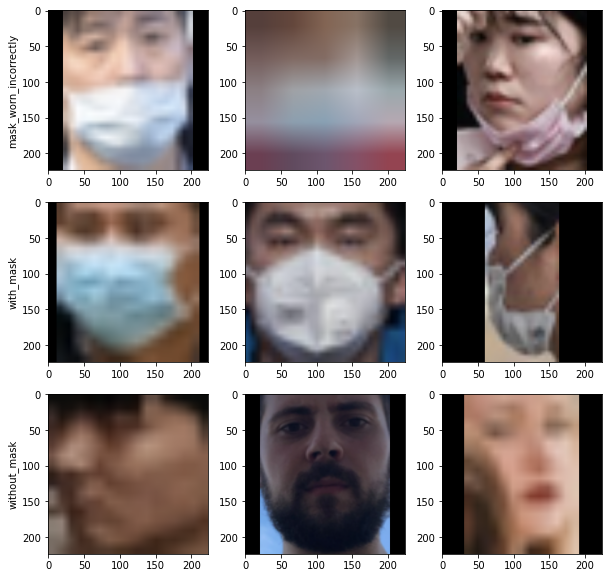

In [5]:
im_0 = cv2.imread('/content/gdrive/MyDrive/ANN_Project/dataset/mask_worn_incorrectly/' + mask_worn_incorrectly_names[9])
im_0 = cv2.cvtColor(im_0, cv2.COLOR_BGR2RGB)
im_1 = cv2.imread('/content/gdrive/MyDrive/ANN_Project/dataset/mask_worn_incorrectly/' + mask_worn_incorrectly_names[19])
im_1 = cv2.cvtColor(im_1, cv2.COLOR_BGR2RGB)
im_2 = cv2.imread('/content/gdrive/MyDrive/ANN_Project/dataset/mask_worn_incorrectly/' + mask_worn_incorrectly_names[28])
im_2 = cv2.cvtColor(im_2, cv2.COLOR_BGR2RGB)
im_3 = cv2.imread('/content/gdrive/MyDrive/ANN_Project/dataset/with_mask/' + with_mask_names[31])
im_3 = cv2.cvtColor(im_3, cv2.COLOR_BGR2RGB)
im_4 = cv2.imread('/content/gdrive/MyDrive/ANN_Project/dataset/with_mask/' + with_mask_names[58])
im_4 = cv2.cvtColor(im_4, cv2.COLOR_BGR2RGB)
im_5 = cv2.imread('/content/gdrive/MyDrive/ANN_Project/dataset/with_mask/' + with_mask_names[89])
im_5 = cv2.cvtColor(im_5, cv2.COLOR_BGR2RGB)
im_6 = cv2.imread('/content/gdrive/MyDrive/ANN_Project/dataset/without_mask/' + without_mask_names[30])
im_6 = cv2.cvtColor(im_6, cv2.COLOR_BGR2RGB)
im_7 = cv2.imread('/content/gdrive/MyDrive/ANN_Project/dataset/without_mask/' + without_mask_names[190])
im_7 = cv2.cvtColor(im_7, cv2.COLOR_BGR2RGB)
im_8 = cv2.imread('/content/gdrive/MyDrive/ANN_Project/dataset/without_mask/' + without_mask_names[17])
im_8 = cv2.cvtColor(im_8, cv2.COLOR_BGR2RGB)
 
plt.subplots(figsize=(10, 10))
 
plt.subplot(3, 3, 1)
plt.ylabel('mask_worn_incorrectly')
plt.imshow(im_0)
 
plt.subplot(3, 3, 2)
plt.imshow(im_1)
 
plt.subplot(3, 3, 3)
plt.imshow(im_2)
 
plt.subplot(3, 3, 4)
plt.ylabel('with_mask')
plt.imshow(im_3)
 
plt.subplot(3, 3, 5)
plt.imshow(im_4)
 
plt.subplot(3, 3, 6)
plt.imshow(im_5)
 
plt.subplot(3, 3, 7)
plt.ylabel('without_mask')
plt.imshow(im_6)
 
plt.subplot(3, 3, 8)
plt.imshow(im_7)
 
plt.subplot(3, 3, 9)
plt.imshow(im_8)
 
plt.show()
 
########################################################################################################################
 
os.makedirs('/content/gdrive/MyDrive/ANN_Project/dataset/Train/', exist_ok=True)
os.makedirs('/content/gdrive/MyDrive/ANN_Project/dataset/Train/mask_worn_incorrectly/', exist_ok=True)
os.makedirs('/content/gdrive/MyDrive/ANN_Project/dataset/Train/with_mask/', exist_ok=True)
os.makedirs('/content/gdrive/MyDrive/ANN_Project/dataset/Train/without_mask/', exist_ok=True)
os.makedirs('/content/gdrive/MyDrive/ANN_Project/dataset/Test/', exist_ok=True)
os.makedirs('/content/gdrive/MyDrive/ANN_Project/dataset/Test/mask_worn_incorrectly/', exist_ok=True)
os.makedirs('/content/gdrive/MyDrive/ANN_Project/dataset/Test/with_mask/', exist_ok=True)
os.makedirs('/content/gdrive/MyDrive/ANN_Project/dataset/Test/without_mask/', exist_ok=True)
 
for i in range(len(mask_worn_incorrectly_names)):
    if i <= split_rate * len(mask_worn_incorrectly_names):
        shutil.copy('/content/gdrive/MyDrive/ANN_Project/dataset/mask_worn_incorrectly/' + mask_worn_incorrectly_names[i],
                    '/content/gdrive/MyDrive/ANN_Project/dataset/Train/mask_worn_incorrectly/')
    else:
        shutil.copy('/content/gdrive/MyDrive/ANN_Project/dataset/mask_worn_incorrectly/' + mask_worn_incorrectly_names[i],
                    '/content/gdrive/MyDrive/ANN_Project/dataset/Test/mask_worn_incorrectly/')
 
for i in range(len(with_mask_names)):
    if i <= split_rate * len(with_mask_names):
        shutil.copy('/content/gdrive/MyDrive/ANN_Project/dataset/with_mask/' + with_mask_names[i],
                    '/content/gdrive/MyDrive/ANN_Project/dataset/Train/with_mask/')
    else:
        shutil.copy('/content/gdrive/MyDrive/ANN_Project/dataset/with_mask/' + with_mask_names[i],
                    '/content/gdrive/MyDrive/ANN_Project/dataset/Test/with_mask/')
 
for i in range(len(without_mask_names)):
    if i <= split_rate * len(without_mask_names):
        shutil.copy('/content/gdrive/MyDrive/ANN_Project/dataset/without_mask/' + without_mask_names[i],
                    '/content/gdrive/MyDrive/ANN_Project/dataset/Train/without_mask/')
    else:
        shutil.copy('/content/gdrive/MyDrive/ANN_Project/dataset/without_mask/' + without_mask_names[i],
                    '/content/gdrive/MyDrive/ANN_Project/dataset/Test/without_mask/')

#### Augment the "mask_worn_incorrectly" class x5 times

In [6]:
mask_worn_incorrectly_train = '/content/gdrive/MyDrive/ANN_Project/dataset/Train/mask_worn_incorrectly/'
mask_worn_incorrectly_train_names = os.listdir(mask_worn_incorrectly_train)

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(rotation_range=15,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    brightness_range=(0.3, 1.0),
                                    shear_range=0.05,
                                    channel_shift_range=0.1,
                                    fill_mode="constant",
                                    cval=0.0,
                                    horizontal_flip=True,
                                    vertical_flip=False) 

for f in mask_worn_incorrectly_train_names:
    img = load_img(mask_worn_incorrectly_train + f)  
    x = img_to_array(img) 
    # Reshape the input image 
    x = x.reshape((1, ) + x.shape)  
    i = 0

    # generate 4 new augmented images 
    for batch in datagen.flow(x, batch_size = 1, 
                      save_to_dir = mask_worn_incorrectly_train,  
                      save_prefix ='aug', save_format ='png'):
        i += 1
        if i > 4: 
            break


#### Create data generators

In [8]:
target_size = (224, 224)
 
train_data_gen = ImageDataGenerator(rescale=1. / 255)
test_data_gen = ImageDataGenerator(rescale=1. / 255)
 
train_generator = train_data_gen.flow_from_directory('/content/gdrive/MyDrive/ANN_Project/dataset/Train/', target_size=target_size, batch_size=BS,
                                                     subset='training')
test_generator = test_data_gen.flow_from_directory('/content/gdrive/MyDrive/ANN_Project/dataset/Test/', target_size=target_size, batch_size=BS,
                                                   shuffle=False)

Found 3741 images belonging to 3 classes.
Found 813 images belonging to 3 classes.


#### Define and compile the VGG16 model

In [4]:
feature_extractor = VGG16(weights='imagenet', input_shape=target_size + (3,), include_top=False)
 
for layer in feature_extractor.layers:
    layer.trainable = False
 
num_classes = 3
 
train_folder = '/content/gdrive/MyDrive/ANN_Project/dataset/Train/'
mask_worn_incorrectly_train = os.listdir(train_folder + 'mask_worn_incorrectly')
c0 = len(mask_worn_incorrectly_train)
with_mask_train = os.listdir(train_folder + 'with_mask')
c1 = len(with_mask_train)
without_mask_train = os.listdir(train_folder + 'without_mask')
c2 = len(without_mask_train)

print(c0, c1, c2)

c_sum = c0+c1+c2

 
class0 = math.exp(c0/c_sum)
 
class1 = math.exp(c1/c_sum)
 
class2 = math.exp(c2/c_sum)
 
exp_sum = class0 + class1 + class2
 
freq0 = class0 / exp_sum
 
freq1 = class1 / exp_sum
 
freq2 = class2 / exp_sum
 
biases = np.array([freq0, freq1, freq2])
 
inp_layer = Input(shape=target_size + (3,))
layer = feature_extractor(inp_layer)
layer = Flatten()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(16, activation='linear')(layer)
layer = PReLU()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(16, activation='linear')(layer)
layer = PReLU()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(8, activation='linear')(layer)
layer = PReLU()(layer)
layer = Dropout(0.2)(layer)
out_layer = Dense(num_classes, activation='softmax', use_bias=True, bias_initializer=constant(biases))(layer)
 
my_model = Model(inp_layer, out_layer)
my_model.summary()

my_model.compile(Adam(), loss=categorical_crossentropy, metrics='acc')

58892288/58889256 [==============================] - 1s 0us/step
581 2586 574
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                401424    
_________________________________________________________________
p_re_lu (PReLU)              (None, 16)                16        
_________________________________________________

#### Training the VGG16 model

In [ ]:
checkpoint_path = '/content/gdrive/MyDrive/ANN_Project/temp/checkpoint2'
 
callback1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_loss',
                                               save_best_only=True)
class_weight = {0: c0/c1,
                1: 1,
                2: c2/c1}
 
start = datetime.datetime.now()
results = my_model.fit(train_generator, epochs=100, validation_data=test_generator, class_weight=class_weight,
                       callbacks=[callback1])
end = datetime.datetime.now()
elapsed = end - start
print('Total training time =', str(elapsed))
 
# Load the model weights with the best results
#my_model.load_weights(checkpoint_path)
 
train_generator.shuffle = False
 
temp = my_model.predict(train_generator)  # It takes one redundant prediction for shuffle to turn off

Epoch 1/100
13/13 [==============================] - 22s 2s/step - loss: 0.2469 - acc: 0.4906 - val_loss: 1.0421 - val_acc: 0.4785
Epoch 2/100
13/13 [==============================] - 20s 1s/step - loss: 0.2429 - acc: 0.4532 - val_loss: 1.0203 - val_acc: 0.5252
Epoch 3/100
13/13 [==============================] - 20s 1s/step - loss: 0.2357 - acc: 0.5124 - val_loss: 1.0661 - val_acc: 0.3346
Epoch 4/100
13/13 [==============================] - 20s 1s/step - loss: 0.2464 - acc: 0.6293 - val_loss: 1.0065 - val_acc: 0.7958
Epoch 5/100
13/13 [==============================] - 19s 1s/step - loss: 0.2434 - acc: 0.6361 - val_loss: 1.0316 - val_acc: 0.5326
Epoch 6/100
13/13 [==============================] - 19s 1s/step - loss: 0.2266 - acc: 0.5677 - val_loss: 1.0799 - val_acc: 0.2337
Epoch 7/100
13/13 [==============================] - 20s 1s/step - loss: 0.2276 - acc: 0.4811 - val_loss: 1.0048 - val_acc: 0.6125
Epoch 8/100
13/13 [==============================] - 20s 1s/step - loss: 0.2190 - a

#### Results of the VGG16 model


Training Data Confusion Matrix:
[[  99    0    0]
 [  14 2552   20]
 [   0    9  565]]

Training Data Classification Metrics Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        99
           1       1.00      0.99      0.99      2586
           2       0.97      0.98      0.97       574

    accuracy                           0.99      3259
   macro avg       0.95      0.99      0.97      3259
weighted avg       0.99      0.99      0.99      3259



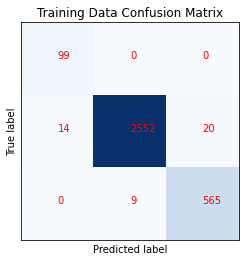


Test Data Confusion Matrix:
[[  9  12   3]
 [  4 622  20]
 [  1  24 118]]

Test Data Classification Metrics Report:
              precision    recall  f1-score   support

           0       0.64      0.38      0.47        24
           1       0.95      0.96      0.95       646
           2       0.84      0.83      0.83       143

    accuracy                           0.92       813
   macro avg       0.81      0.72      0.75       813
weighted avg       0.92      0.92      0.92       813



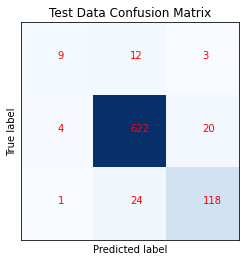

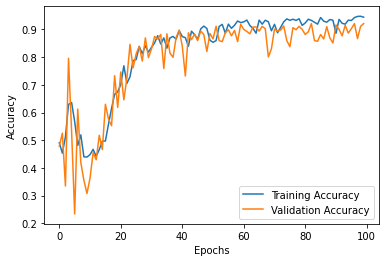

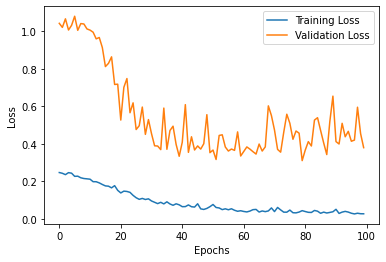

In [ ]:
# Evaluating the network on training data
%matplotlib inline
train_pred_results = my_model.predict(train_generator)
y_pred_train = np.empty(train_pred_results.shape[0])
for i in range(train_pred_results.shape[0]):
    y_pred_train[i] = np.argmax(train_pred_results[i, :])
cnf_train = confusion_matrix(train_generator.classes, y_pred_train)
print('\nTraining Data Confusion Matrix:')
print(cnf_train)  # Confusion Matrix
cls_report_train = classification_report(train_generator.classes, y_pred_train)
print('\nTraining Data Classification Metrics Report:')
print(cls_report_train)  # Classification Metrics Report
 
plt.figure()
plt.imshow(cnf_train, cmap='Blues')
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(i, j, cnf_train[j, i], fontdict={'color': 'red'})
plt.xticks([])
plt.yticks([])
plt.title('Training Data Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
 
# Evaluating the network on test data
test_pred_results = my_model.predict(test_generator)
y_pred_test = np.empty(test_pred_results.shape[0])
for i in range(test_pred_results.shape[0]):
    y_pred_test[i] = np.argmax(test_pred_results[i, :])
cnf_test = confusion_matrix(test_generator.classes, y_pred_test)
print('\nTest Data Confusion Matrix:')
print(cnf_test)  # Confusion Matrix
cls_report_test = classification_report(test_generator.classes, y_pred_test)
print('\nTest Data Classification Metrics Report:')
print(cls_report_test)  # Classification Metrics Report
 
plt.figure()
plt.imshow(cnf_test, cmap='Blues')
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(i, j, cnf_test[j, i], fontdict={'color': 'red'})
plt.xticks([])
plt.yticks([])
plt.title('Test Data Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
 
# Plotting The Results
# Accuracy
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
# Loss
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])

#### Define and compile the MobileNet model

In [9]:
feature_extractor = MobileNetV2(weights='imagenet', input_shape=target_size + (3,), include_top=False)
 
for layer in feature_extractor.layers:
    layer.trainable = False
 
num_classes = 3
 
train_folder = '/content/gdrive/MyDrive/ANN_Project/dataset/Train/'
mask_worn_incorrectly_train = os.listdir(train_folder + 'mask_worn_incorrectly')
c0 = len(mask_worn_incorrectly_train)
with_mask_train = os.listdir(train_folder + 'with_mask')
c1 = len(with_mask_train)
without_mask_train = os.listdir(train_folder + 'without_mask')
c2 = len(without_mask_train)

print(c0, c1, c2)

c_sum = c0+c1+c2

 
class0 = math.exp(c0/c_sum)
 
class1 = math.exp(c1/c_sum)
 
class2 = math.exp(c2/c_sum)
 
exp_sum = class0 + class1 + class2
 
freq0 = class0 / exp_sum
 
freq1 = class1 / exp_sum
 
freq2 = class2 / exp_sum
 
biases = np.array([freq0, freq1, freq2])
 
inp_layer = Input(shape=target_size + (3,))
layer = feature_extractor(inp_layer)
layer = Flatten()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(16, activation='linear')(layer)
layer = PReLU()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(16, activation='linear')(layer)
layer = PReLU()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(8, activation='linear')(layer)
layer = PReLU()(layer)
layer = Dropout(0.2)(layer)
out_layer = Dense(num_classes, activation='softmax', use_bias=True, bias_initializer=constant(biases))(layer)
 
my_model = Model(inp_layer, out_layer)
my_model.summary()

my_model.compile(Adam(), loss=categorical_crossentropy, metrics='acc')

9412608/9406464 [==============================] - 0s 0us/step
581 2586 574
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1003536   
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 16)                16        
_________________________________________________

#### Training the MobileNet model

In [ ]:
checkpoint_path = '/content/gdrive/MyDrive/ANN_Project/temp/checkpoint2'
 
callback1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_loss',
                                               save_best_only=True)
class_weight = {0: c0/c1,
                1: 1,
                2: c2/c1}
 
start = datetime.datetime.now()
results = my_model.fit(train_generator, epochs=100, validation_data=test_generator, class_weight=class_weight,
                       callbacks=[callback1])
end = datetime.datetime.now()
elapsed = end - start
print('Total training time =', str(elapsed))
 
# Load the model weights with the best results
#my_model.load_weights(checkpoint_path)
 
train_generator.shuffle = False
 
temp = my_model.predict(train_generator)  # It takes one redundant prediction for shuffle to turn off

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
13/13 [==============================] - 51s 1s/step - loss: 0.4452 - acc: 0.2415 - val_loss: 1.0904 - val_acc: 0.4711
Epoch 2/100
13/13 [==============================] - 17s 1s/step - loss: 0.2500 - acc: 0.4271 - val_loss: 1.0046 - val_acc: 0.7946
Epoch 3/100
13/13 [==============================] - 17s 1s/step - loss: 0.2476 - acc: 0.6072 - val_loss: 1.0157 - val_acc: 0.7835
Epoch 4/100
13/13 [==============================] - 17s 1s/step - loss: 0.2458 - acc: 0.4919 - val_loss: 1.0001 - val_acc: 0.7983
Epoch 5/100
13/13 [==============================] - 17s 1s/step - loss: 0.2439 - acc: 0.4093 - val_loss: 1.0092 - val_acc: 0.7823
Epoch 6/100
13/13 [==============================] - 17s 1s/step - loss: 0.2379 - acc: 0.4624 - val_loss: 1.0320 - val_acc: 0.6494
Epoch 7/100
13/13 [==============================] - 17s 1s/step - loss: 0.2

#### Results of the MobileNet model


Training Data Confusion Matrix:
[[  99    0    0]
 [   0 2586    0]
 [   0    0  574]]

Training Data Classification Metrics Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      1.00      1.00      2586
           2       1.00      1.00      1.00       574

    accuracy                           1.00      3259
   macro avg       1.00      1.00      1.00      3259
weighted avg       1.00      1.00      1.00      3259



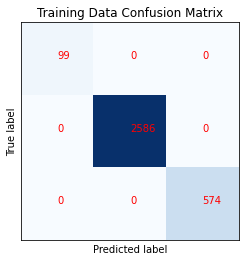


Test Data Confusion Matrix:
[[ 10  13   1]
 [  0 629  17]
 [  0  40 103]]

Test Data Classification Metrics Report:
              precision    recall  f1-score   support

           0       1.00      0.42      0.59        24
           1       0.92      0.97      0.95       646
           2       0.85      0.72      0.78       143

    accuracy                           0.91       813
   macro avg       0.92      0.70      0.77       813
weighted avg       0.91      0.91      0.91       813



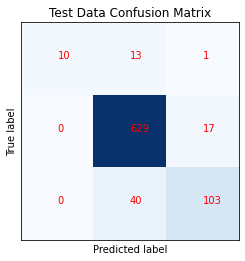

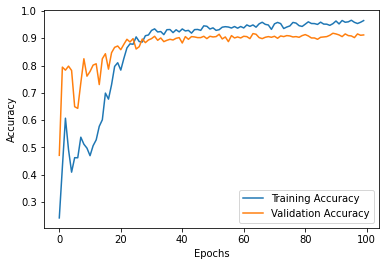

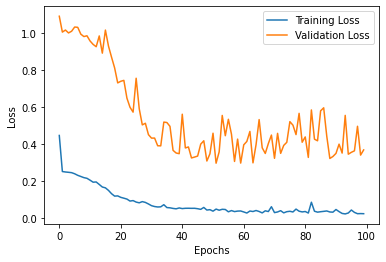

In [ ]:
# Evaluating the network on training data
%matplotlib inline
train_pred_results = my_model.predict(train_generator)
y_pred_train = np.empty(train_pred_results.shape[0])
for i in range(train_pred_results.shape[0]):
    y_pred_train[i] = np.argmax(train_pred_results[i, :])
cnf_train = confusion_matrix(train_generator.classes, y_pred_train)
print('\nTraining Data Confusion Matrix:')
print(cnf_train)  # Confusion Matrix
cls_report_train = classification_report(train_generator.classes, y_pred_train)
print('\nTraining Data Classification Metrics Report:')
print(cls_report_train)  # Classification Metrics Report
 
plt.figure()
plt.imshow(cnf_train, cmap='Blues')
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(i, j, cnf_train[j, i], fontdict={'color': 'red'})
plt.xticks([])
plt.yticks([])
plt.title('Training Data Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
 
# Evaluating the network on test data
test_pred_results = my_model.predict(test_generator)
y_pred_test = np.empty(test_pred_results.shape[0])
for i in range(test_pred_results.shape[0]):
    y_pred_test[i] = np.argmax(test_pred_results[i, :])
cnf_test = confusion_matrix(test_generator.classes, y_pred_test)
print('\nTest Data Confusion Matrix:')
print(cnf_test)  # Confusion Matrix
cls_report_test = classification_report(test_generator.classes, y_pred_test)
print('\nTest Data Classification Metrics Report:')
print(cls_report_test)  # Classification Metrics Report
 
plt.figure()
plt.imshow(cnf_test, cmap='Blues')
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(i, j, cnf_test[j, i], fontdict={'color': 'red'})
plt.xticks([])
plt.yticks([])
plt.title('Test Data Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
 
# Plotting The Results
# Accuracy
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
# Loss
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])